# Homework 6: Decision Trees and Ensemble Learning

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.



### Dataset

In this homework, we will use the California Housing Prices from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices).

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
```

In [1]:
#!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

The goal of this homework is to create a regression model for predicting housing prices (column `'median_house_value'`).


### Preparing the dataset 

For this homework, we only want to use a subset of data. This is the same subset we used in homework #2.
But in contrast to homework #2 we are going to use all columns of the dataset.

First, keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`

Preparation:

* Fill missing values with zeros.
* Apply the log tranform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [3]:
def prep_data(df, columns, labels):
    df_filt = df.loc[(df['ocean_proximity'] == '<1H OCEAN') | (df['ocean_proximity'] == 'INLAND')]
    df_clean = df_filt[columns].fillna(0)
    df_clean = df_clean.join(np.log1p(df[labels]))
    df_clean.columns = df_clean.columns.str.replace(' ', '_').str.lower()
    
    return df_clean

In [4]:
def split_data(df):
    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    return df_train, df_val, df_test

In [5]:
def prepare_data_dict(split_df, labelcol):
    y = split_df[labelcol].values
    split_df_copy = split_df.copy()
    del(split_df_copy[labels])
    train_dict = split_df_copy.to_dict(orient='records')
    
    return train_dict, y

In [6]:
df = pd.read_csv('housing.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [8]:
numerical = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
             'total_bedrooms', 'population', 'households', 'median_income']
categorical = ['ocean_proximity']
columns = numerical + categorical
labels = 'median_house_value'

df_clean=prep_data(df, columns, labels)
df_train, df_val, df_test = split_data(df_clean)

In [9]:
Xtrain_dict, y_train = prepare_data_dict(df_train, labels)
Xval_dict, y_val = prepare_data_dict(df_val, labels)
Xtest_dict, y_test = prepare_data_dict(df_test, labels)

In [10]:
dv = DictVectorizer(sparse=True)

X_train = dv.fit_transform(Xtrain_dict)
X_val = dv.transform(Xval_dict)
X_test = dv.transform(Xtest_dict)

In [11]:
X_train

<9411x10 sparse matrix of type '<class 'numpy.float64'>'
	with 84699 stored elements in Compressed Sparse Row format>

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.

In [12]:
dtr = DecisionTreeRegressor(max_depth=1)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [13]:
print(export_text(dtr, feature_names=dv.get_feature_names_out()))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



Which feature is used for splitting the data?

* `ocean_proximity`  <--
* `total_rooms`
* `latitude`
* `population`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)

In [14]:
rfr = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)

rfr.fit(X_train, y_train)

yval_pred = rfr.predict(X_val)
RMSE = mean_squared_error(y_val, yval_pred, squared=False)
print(f'RMSE: {round(RMSE, 3)}')

RMSE: 0.245


What's the RMSE of this model on validation?

* 0.045
* 0.245 <--
* 0.545
* 0.845

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.

In [15]:
estimators = np.arange(10,201, 10)
rmses = []

for n in estimators:
    rfr = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    
    print(f'Fitting: n_estimators = {n}')
    rfr.fit(X_train, y_train)

    yval_pred = rfr.predict(X_val)
    RMSE = mean_squared_error(y_val, yval_pred, squared=False)
    rmses.append(round(RMSE, 3))
    
print(rmses)

Fitting: n_estimators = 10
Fitting: n_estimators = 20
Fitting: n_estimators = 30
Fitting: n_estimators = 40
Fitting: n_estimators = 50
Fitting: n_estimators = 60
Fitting: n_estimators = 70
Fitting: n_estimators = 80
Fitting: n_estimators = 90
Fitting: n_estimators = 100
Fitting: n_estimators = 110
Fitting: n_estimators = 120
Fitting: n_estimators = 130
Fitting: n_estimators = 140
Fitting: n_estimators = 150
Fitting: n_estimators = 160
Fitting: n_estimators = 170
Fitting: n_estimators = 180
Fitting: n_estimators = 190
Fitting: n_estimators = 200
[0.245, 0.238, 0.237, 0.235, 0.235, 0.235, 0.234, 0.235, 0.234, 0.234, 0.234, 0.234, 0.234, 0.234, 0.234, 0.233, 0.233, 0.234, 0.234, 0.234]


In [16]:
rmses

[0.245,
 0.238,
 0.237,
 0.235,
 0.235,
 0.235,
 0.234,
 0.235,
 0.234,
 0.234,
 0.234,
 0.234,
 0.234,
 0.234,
 0.234,
 0.233,
 0.233,
 0.234,
 0.234,
 0.234]

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

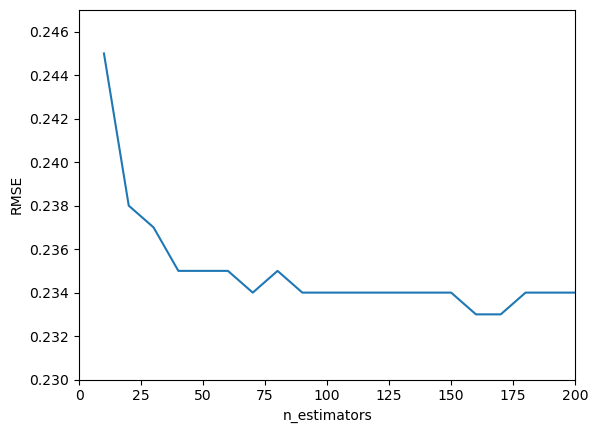

In [17]:
plt.plot(estimators, rmses, label='RMSE')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.xlim((0, 200))
plt.ylim((0.230, 0.247))
plt.plot

After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for retrieving the answer.

- 10
- 25
- 50
- 160  <--

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE 
* Fix the random seed: `random_state=1`

In [48]:
estimators = np.arange(10,201, 10)
depths = [10, 15, 20, 25]
scores=[]

for d in depths:
    for n in estimators:
        rfr = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rfr.fit(X_train, y_train)

        yval_pred = rfr.predict(X_val)
        RMSE = mean_squared_error(y_val, yval_pred, squared=False)
        
        scores.append((d, n, round(RMSE, 4)))
        print(scores[-1])

(10, 10, 0.2507)
(10, 20, 0.2475)
(10, 30, 0.2463)
(10, 40, 0.245)
(10, 50, 0.2454)
(10, 60, 0.2452)
(10, 70, 0.2453)
(10, 80, 0.2455)
(10, 90, 0.2455)
(10, 100, 0.2454)
(10, 110, 0.2453)
(10, 120, 0.2451)
(10, 130, 0.2448)
(10, 140, 0.2446)
(10, 150, 0.2446)
(10, 160, 0.2445)
(10, 170, 0.2444)
(10, 180, 0.2445)
(10, 190, 0.2447)
(10, 200, 0.2447)
(15, 10, 0.2457)
(15, 20, 0.2395)
(15, 30, 0.2378)
(15, 40, 0.2359)
(15, 50, 0.2359)
(15, 60, 0.2356)
(15, 70, 0.2355)
(15, 80, 0.2358)
(15, 90, 0.2354)
(15, 100, 0.2353)
(15, 110, 0.2352)
(15, 120, 0.2349)
(15, 130, 0.2348)
(15, 140, 0.2346)
(15, 150, 0.2345)
(15, 160, 0.2343)
(15, 170, 0.2343)
(15, 180, 0.2345)
(15, 190, 0.2347)
(15, 200, 0.2345)
(20, 10, 0.2453)
(20, 20, 0.239)
(20, 30, 0.2371)
(20, 40, 0.2355)
(20, 50, 0.2351)
(20, 60, 0.2348)
(20, 70, 0.2347)
(20, 80, 0.2349)
(20, 90, 0.2348)
(20, 100, 0.2346)
(20, 110, 0.2344)
(20, 120, 0.2342)
(20, 130, 0.234)
(20, 140, 0.2339)
(20, 150, 0.2338)
(20, 160, 0.2337)
(20, 170, 0.2337)
(20,

<Axes: xlabel='None-max_depth', ylabel='n_estimators'>

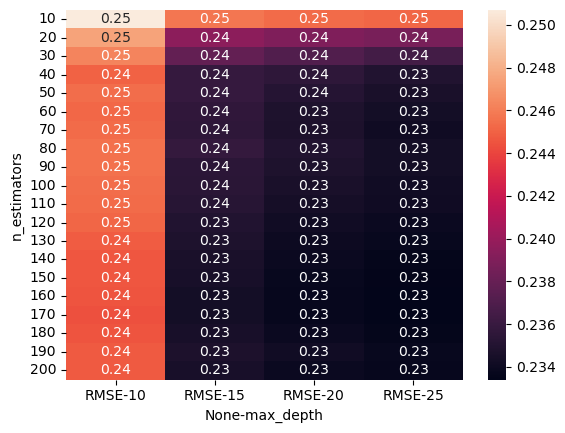

In [55]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'RMSE'])
df_scores_pivot = df_scores.pivot(index='n_estimators', columns=['max_depth'], values=['RMSE'])

sns.heatmap(df_scores_pivot, annot=True)

In [59]:
mean_rmse_by_d = df_scores.groupby('max_depth')['RMSE'].mean().round(4)
print(mean_rmse_by_d)

max_depth
10    0.2454
15    0.2359
20    0.2353
25    0.2349
Name: RMSE, dtype: float64


What's the best `max_depth`, using the mean RMSE?

* 10
* 15
* 20
* 25  <--

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model


In [70]:
rfr = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rfr.fit(X_train, y_train)

importances = rfr.feature_importances_

In [71]:
featurenames = dv.get_feature_names_out()

In [79]:
feature_df = pd.DataFrame(list(zip(featurenames, importances)), \
                          columns=['feature', 'importance']).sort_values(by=['importance'], ascending=False)
print(feature_df)

                     feature  importance
4              median_income    0.335668
5  ocean_proximity=<1H OCEAN    0.292473
2                   latitude    0.101891
3                  longitude    0.086176
6     ocean_proximity=INLAND    0.073806
1         housing_median_age    0.030194
7                 population    0.026821
9                total_rooms    0.021772
8             total_bedrooms    0.016245
0                 households    0.014953


What's the most important feature (among these 4)? 

* `total_rooms`
* `median_income`  <--
* `total_bedrooms`
* `longitude`


# Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```


In [18]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/c1/cf/a662bc8f40588d54663edfe12980946670490bff0b6e793c7896a4fe36df/xgboost-2.0.0-py3-none-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 3.3 MB/s eta 0:00:000m eta 0:00:010:00:01


In [19]:
import xgboost as xgb

In [24]:
featurenames = dv.get_feature_names_out()
featurenames = [i.replace("<", "lessthan") for i in featurenames]
dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = featurenames)
dval = xgb.DMatrix(X_val, label = y_val, feature_names = featurenames)

In [29]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

xgb.train(xgb_params, dtrain, num_boost_round = 100,
          evals=watchlist, verbose_eval=10)

[0]	train-rmse:0.44350	val-rmse:0.44250
[10]	train-rmse:0.21444	val-rmse:0.25179
[20]	train-rmse:0.18524	val-rmse:0.23978
[30]	train-rmse:0.16888	val-rmse:0.23570
[40]	train-rmse:0.15542	val-rmse:0.23318
[50]	train-rmse:0.14536	val-rmse:0.23225
[60]	train-rmse:0.13719	val-rmse:0.23139
[70]	train-rmse:0.12943	val-rmse:0.23068
[80]	train-rmse:0.12192	val-rmse:0.22886
[90]	train-rmse:0.11496	val-rmse:0.22861
[99]	train-rmse:0.10989	val-rmse:0.22862


In [30]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

xgb.train(xgb_params, dtrain, num_boost_round = 100,
          evals=watchlist, verbose_eval=10)

[0]	train-rmse:0.52449	val-rmse:0.52045
[10]	train-rmse:0.30326	val-rmse:0.31427
[20]	train-rmse:0.24512	val-rmse:0.26882
[30]	train-rmse:0.21887	val-rmse:0.25266
[40]	train-rmse:0.20392	val-rmse:0.24539
[50]	train-rmse:0.19215	val-rmse:0.24020
[60]	train-rmse:0.18457	val-rmse:0.23791
[70]	train-rmse:0.17741	val-rmse:0.23622
[80]	train-rmse:0.17242	val-rmse:0.23453
[90]	train-rmse:0.16797	val-rmse:0.23332
[99]	train-rmse:0.16323	val-rmse:0.23209


Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3  <--
* 0.1  
* Both give equal value

## Submit the results

- Submit your results here: https://forms.gle/Qa2SuzG7QGZNCaoV9
- If your answer doesn't match options exactly, select the closest one.
- You can submit your solution multiple times. In this case, only the last submission will be used

## Deadline

The deadline for submitting is October 23 (Monday), 23:00 CET. After that the form will be closed.